In [1]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

In [2]:
def filter_anomalous_cases(mapping, filter_or_select='filter'):

    anomalous_cases = {
        'benign': [435, 433, 42, 131, 437, 269, 333, 399, 403, 406, 85, 164, 61, 94, 108, 114, 116, 119, 122, 201, 302,
                   394, 402, 199, 248, 242, 288, 236, 247, 233, 299, 4, 321, 25, 153],
        'malignant': [145, 51, 77, 78, 93, 94, 52, 106, 107, 18, 116],
        'normal': [34, 1]
    }
    
    mapping.reset_index(drop=True, inplace=True)
    mapping_result = mapping.copy()
    

    for cls, ids in anomalous_cases.items():
        mapping_result = mapping_result[~((mapping_result['class'] == cls) & (mapping['patient_id'].isin(ids)))]

    if filter_or_select == 'select':
        index_not_out = mapping_result.index.values.tolist()
        mapping_result = mapping.loc[~mapping.index.isin(index_not_out)]
        

    return mapping_result

In [3]:
# 20230310_174428_CV_4_normal
# 20230224_131152_CV_4_benign_malignant

path_exp = sorted(glob.glob("./../Results/Experiments/20230310_174428_CV_4_normal/fold*/results.csv"))

In [4]:

results = []
for n, f in enumerate(path_exp):
    df = pd.read_csv(f)
    df["fold"] = n
    results.append(df)

results = pd.concat(results).sort_values(by="patient_id")
print(results.shape)
results.head(3)

(780, 10)


,patient_id,Haussdorf distance,DICE,Sensitivity,Specificity,Accuracy,Jaccard index,Precision,class,fold
109,1,9.0,0.891726,0.875564,0.954885,0.928040,0.804607,0.908496,malignant,1
162,1,NaN,0.000000,NaN,0.899231,0.899231,0.000000,NaN,normal,2
0,1,2.0,0.881890,0.933333,0.999326,0.999084,0.788732,0.835821,benign,1


In [5]:
results_grouped = results.groupby("fold").mean().reset_index(drop=True)
print(f"DICE: {round(100 * results_grouped.DICE.mean(), 2)} +- {round(100 * results_grouped.DICE.std(), 2)}")
print(f"Sensitivity: {round(100 * results_grouped.Sensitivity.mean(), 2)} +- {round(100 * results_grouped.Sensitivity.std(), 2)}")
print(f"Specificity: {round(100 * results_grouped.Specificity.mean(), 2)} +- {round(100 * results_grouped.Specificity.std(), 2)}")
print(f"Precision: {round(100 * results_grouped.Precision.mean(), 2)} +- {round(100 * results_grouped.Precision.std(), 2)}")
print(f"Jaccard: {round(100 * results_grouped['Jaccard index'].mean(), 2)} +- {round(100 * results_grouped['Jaccard index'].std(), 2)}")

DICE: 68.78 +- 6.73
Sensitivity: 81.98 +- 2.05
Specificity: 97.08 +- 1.37
Precision: 82.05 +- 4.46
Jaccard: 61.37 +- 7.12


In [6]:
df_no_outliers = filter_anomalous_cases(results, 'filter')
df_outliers = filter_anomalous_cases(results, 'select')

print(f"No outliers shape: {df_no_outliers.shape[0]}. Outliers shape: {df_outliers.shape[0]}.")

No outliers shape: 732. Outliers shape: 48.


(0.2031190442027534, 0.0009999999999998899)

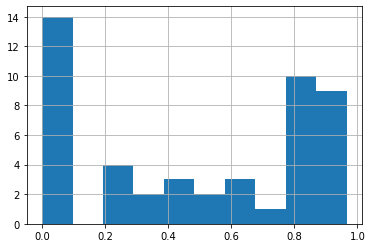

In [7]:
df_outliers.DICE.hist()
lilliefors(df_outliers.DICE)

(0.26649546775852956, 0.0009999999999998899)

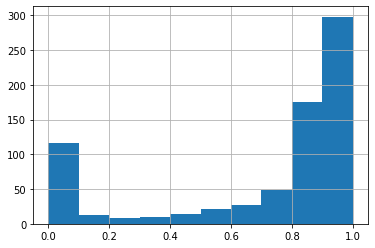

In [8]:
df_no_outliers.DICE.hist()
lilliefors(df_no_outliers.DICE)

In [9]:
mannwhitneyu(df_no_outliers.DICE, df_outliers.DICE)

MannwhitneyuResult(statistic=23807.5, pvalue=3.593709692631403e-05)

In [10]:
# mannwhitneyu(df_no_outliers.sample(46).DICE, df_no_outliers.sample(46).DICE)